# Coursera IBM Machine Learning - Unsupervised Learning - Final Project

In [17]:
import polars as pl
import polars.selectors as ps
import seaborn as sns

rs = 42

I have chosen the [Kaggle Spotify Audio Features dataset](https://www.kaggle.com/datasets/amitanshjoshi/spotify-1million-tracks) for my final project.

This dataset contains lots of information about track in the form of "Audio Features". These are characteristics of music defined by Spotify that tell something about a specific property of the music. For example, "Acousticness" is a measure of how much the music contains acoustic instruments, as opposed to electronic instruments. "Danceability" and "Energy" are two other measures which seem related, but encode different types of energy in a track. More information about the meaning of the audio features can be found on the [Spotify Developer Website](https://developer.spotify.com/documentation/web-api/reference/get-audio-features).

## Project Goal

The dataset contains a column with the genre of the track. However, I am interested in looking at whether genre is actually a good measure of where a track belongs in the Audio Feature space. Supervised learning was used to group similar songs together based on audio features. Since advanced clustering methods can be slow, I will also reduce the dimensionality of the feature space as much as possible using PCA. As we will also see, there is some redundancy in the audio features due to correlations.
It is unlikely that direct genres can be recovered from the audio features as different genres can often have similar audio feature parametrizations, but it's expected that some clear groups of similarly classifiable tracks emerge.

### Models

- PCA is used for dimensionality reduction
- Gaussian Mixtures are used for grouping similar tracks together
- HDBSCAN for verifying the results of GMM. 

Reducing the dimensionality helps with model fitting, the dataset is very large (>1.000.000 rows) and as such will take a lot of computing power. Reducing the dimensionality by a few components will already help a lot for model selection iteration. As we will see, the data does not contain any natural clusters. Therefore I have chosen GMM to interpret latent features and soft clusters. Relating these back to the original data will give some insight into how tracks group together based on audio features.

Finally, for additional interpretability I will use HDBSCAN to verify the results. I attempted to use an agglomerative model, which would have been interesting since it builds clusters by combining similar subclusters, something that sounds like it would fit a dataset of music properties. But I ran into scaling issues where the amount of memory was too much for my system to handle. Another attempt was made with Factor Analysis, but it seems this dataset is not suited for this analysis, as I ran into numerical issues during the fitting. There is likely a way to make factor analysis work for this dataset, but since that is not aligned with the goal of this report that will have to be postponed.

## Data Description

- 20 features
    - 'id' -> Int
    - 'artist_name' -> String
    - 'track_name' -> String
    - 'track_id' -> String
    - 'popularity' -> Int
    - 'year' -> Int
    - 'genre' -> String
    - 'acousticness' -> Float
    - 'danceability' -> Float
    - 'duration_ms' -> Int
    - 'energy' -> Float
    - 'instrumentalness' -> Float
    - 'key' -> Int
    - 'liveness' -> Float
    - 'loudness' -> Float
    - 'mode' -> Int
    - 'speechiness' -> Float
    - 'tempo' -> Float
    - 'time_signature' -> Int
    - 'valence' -> Float
    
- 1159764 rows

In this analysis we'll restrict ourselves to the actual audio feature columns (acousticness, danceability, energy, instrumentalness, liveness, speechiness, valence), leaving 8 features to consider.

First we will investigate how much these features cover the variance of the data by performing PCA. It might be that some features are redundant or capture similar properties. 

Then we use a gaussian mixture model to investigate which clusters are present in the data.

Finally hierarchical clustering is used to find out the process of clustering.

In [10]:
data_original = pl.read_csv("./data/spotify_data.csv")
print(data_original.shape)
data_original.head()

(1159764, 20)


shape: (5, 20)
┌─────┬─────────────┬─────────────┬─────────────┬───┬─────────┬─────────┬─────────────┬────────────┐
│     ┆ artist_name ┆ track_name  ┆ track_id    ┆ … ┆ valence ┆ tempo   ┆ duration_ms ┆ time_signa │
│ --- ┆ ---         ┆ ---         ┆ ---         ┆   ┆ ---     ┆ ---     ┆ ---         ┆ ture       │
│ i64 ┆ str         ┆ str         ┆ str         ┆   ┆ f64     ┆ f64     ┆ i64         ┆ ---        │
│     ┆             ┆             ┆             ┆   ┆         ┆         ┆             ┆ i64        │
╞═════╪═════════════╪═════════════╪═════════════╪═══╪═════════╪═════════╪═════════════╪════════════╡
│ 0   ┆ Jason Mraz  ┆ I Won't     ┆ 53QF56cjZA9 ┆ … ┆ 0.139   ┆ 133.406 ┆ 240166      ┆ 3          │
│     ┆             ┆ Give Up     ┆ RTuuMZDrSA6 ┆   ┆         ┆         ┆             ┆            │
│ 1   ┆ Jason Mraz  ┆ 93 Million  ┆ 1s8tP3jP4GZ ┆ … ┆ 0.515   ┆ 140.182 ┆ 216387      ┆ 4          │
│     ┆             ┆ Miles       ┆ cyHDsjvw218 ┆   ┆         ┆         ┆             ┆            │
│ 2   ┆ Joshua      ┆ Do Not Let  ┆ 7BRCa8MPiyu ┆ … ┆ 0.145   ┆ 139.832 ┆ 158960      ┆ 4          │
│     ┆ Hyslop      ┆ Me Go       ┆ vr2VU3O9W0F ┆   ┆         ┆         ┆             ┆            │
│ 3   ┆ Boyce       ┆ Fast Car    ┆ 63wsZUhUZLl ┆ … ┆ 0.508   ┆ 204.961 ┆ 304293      ┆ 4          │
│     ┆ Avenue      ┆             ┆ h1OsyrZq7sz ┆   ┆         ┆         ┆             ┆            │
│ 4   ┆ Andrew      ┆ Sky's Still ┆ 6nXIYClvJAf ┆ … ┆ 0.217   ┆ 171.864 ┆ 244320      ┆ 4          │
│     ┆ Belle       ┆ Blue        ┆ i6ujLiKqEq8 ┆   ┆         ┆         ┆             ┆            │
└─────┴─────────────┴─────────────┴─────────────┴───┴─────────┴─────────┴─────────────┴────────────┘

## EDA and Preprocessing

First, we check if there are any null or nan values/

In [3]:
data_original.null_count()

shape: (1, 20)
┌─────┬─────────────┬────────────┬──────────┬───┬─────────┬───────┬─────────────┬────────────────┐
│     ┆ artist_name ┆ track_name ┆ track_id ┆ … ┆ valence ┆ tempo ┆ duration_ms ┆ time_signature │
│ --- ┆ ---         ┆ ---        ┆ ---      ┆   ┆ ---     ┆ ---   ┆ ---         ┆ ---            │
│ u32 ┆ u32         ┆ u32        ┆ u32      ┆   ┆ u32     ┆ u32   ┆ u32         ┆ u32            │
╞═════╪═════════════╪════════════╪══════════╪═══╪═════════╪═══════╪═════════════╪════════════════╡
│ 0   ┆ 0           ┆ 0          ┆ 0        ┆ … ┆ 0       ┆ 0     ┆ 0           ┆ 0              │
└─────┴─────────────┴────────────┴──────────┴───┴─────────┴───────┴─────────────┴────────────────┘

Below we extract the floating point columns (except 'tempo' and 'loudness') and describe the distribution. Most values are already between 0 and 1 (or extremely close). But since distance based scaling methods can be sensitive to scale, we'll first make sure the scale is uniform.

In [4]:
features = data_original.select(ps.float()).drop(["loudness", "tempo"])
features.describe()

shape: (9, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ danceabili ┆ energy     ┆ speechine ┆ acousticn ┆ instrumen ┆ liveness  ┆ valence   │
│ ---        ┆ ty         ┆ ---        ┆ ss        ┆ ess       ┆ talness   ┆ ---       ┆ ---       │
│ str        ┆ ---        ┆ f64        ┆ ---       ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│            ┆ f64        ┆            ┆ f64       ┆ f64       ┆ f64       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 1.159764e6 ┆ 1.159764e6 ┆ 1.159764e ┆ 1.159764e ┆ 1.159764e ┆ 1.159764e ┆ 1.159764e │
│            ┆            ┆            ┆ 6         ┆ 6         ┆ 6         ┆ 6         ┆ 6         │
│ null_count ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 0.537438   ┆ 0.63967    ┆ 0.092815  ┆ 0.321537  ┆ 0.252349  ┆ 0.223019  ┆ 0.455564  │
│ std        ┆ 0.184478   ┆ 0.270501   ┆ 0.126841  ┆ 0.354987  ┆ 0.365073  ┆ 0.201071  ┆ 0.268519  │
│ min        ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 25%        ┆ 0.413      ┆ 0.454      ┆ 0.0371    ┆ 0.0064    ┆ 0.000001  ┆ 0.0979    ┆ 0.226     │
│ 50%        ┆ 0.55       ┆ 0.694      ┆ 0.0507    ┆ 0.147     ┆ 0.00176   ┆ 0.134     ┆ 0.438     │
│ 75%        ┆ 0.677      ┆ 0.873      ┆ 0.089     ┆ 0.64      ┆ 0.614     ┆ 0.292     ┆ 0.674     │
│ max        ┆ 0.993      ┆ 1.0        ┆ 0.971     ┆ 0.996     ┆ 1.0       ┆ 1.0       ┆ 1.0       │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
mms = MinMaxScaler()
features = pl.DataFrame(mms.fit_transform(features), schema=features.columns)
features.describe()

shape: (9, 8)
┌────────────┬────────────┬────────────┬───────────┬───────────┬───────────┬───────────┬───────────┐
│ statistic  ┆ danceabili ┆ energy     ┆ speechine ┆ acousticn ┆ instrumen ┆ liveness  ┆ valence   │
│ ---        ┆ ty         ┆ ---        ┆ ss        ┆ ess       ┆ talness   ┆ ---       ┆ ---       │
│ str        ┆ ---        ┆ f64        ┆ ---       ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│            ┆ f64        ┆            ┆ f64       ┆ f64       ┆ f64       ┆           ┆           │
╞════════════╪════════════╪════════════╪═══════════╪═══════════╪═══════════╪═══════════╪═══════════╡
│ count      ┆ 1.159764e6 ┆ 1.159764e6 ┆ 1.159764e ┆ 1.159764e ┆ 1.159764e ┆ 1.159764e ┆ 1.159764e │
│            ┆            ┆            ┆ 6         ┆ 6         ┆ 6         ┆ 6         ┆ 6         │
│ null_count ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ mean       ┆ 0.541227   ┆ 0.63967    ┆ 0.095587  ┆ 0.322828  ┆ 0.252349  ┆ 0.223019  ┆ 0.455564  │
│ std        ┆ 0.185778   ┆ 0.270501   ┆ 0.130629  ┆ 0.356413  ┆ 0.365073  ┆ 0.201071  ┆ 0.268519  │
│ min        ┆ 0.0        ┆ 0.0        ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       ┆ 0.0       │
│ 25%        ┆ 0.415911   ┆ 0.454      ┆ 0.038208  ┆ 0.006426  ┆ 0.000001  ┆ 0.0979    ┆ 0.226     │
│ 50%        ┆ 0.553877   ┆ 0.694      ┆ 0.052214  ┆ 0.14759   ┆ 0.00176   ┆ 0.134     ┆ 0.438     │
│ 75%        ┆ 0.681772   ┆ 0.873      ┆ 0.091658  ┆ 0.64257   ┆ 0.614     ┆ 0.292     ┆ 0.674     │
│ max        ┆ 1.0        ┆ 1.0        ┆ 1.0       ┆ 1.0       ┆ 1.0       ┆ 1.0       ┆ 1.0       │
└────────────┴────────────┴────────────┴───────────┴───────────┴───────────┴───────────┴───────────┘

First, let's see which artists are mainly represented in the data to see if there might be an overrepresentation.

In [9]:
(
    data_original
    .group_by("artist_name")
    .agg(pl.len())
    .sort("len", descending=True)
    .head(10)
)

shape: (10, 2)
┌─────────────────────────┬──────┐
│ artist_name             ┆ len  │
│ ---                     ┆ ---  │
│ str                     ┆ u32  │
╞═════════════════════════╪══════╡
│ Traditional             ┆ 4058 │
│ Grateful Dead           ┆ 2320 │
│ Johann Sebastian Bach   ┆ 2125 │
│ Giacomo Meyerbeer       ┆ 1345 │
│ Elvis Presley           ┆ 1242 │
│ Wolfgang Amadeus Mozart ┆ 1084 │
│ Armin van Buuren        ┆ 1061 │
│ Astor Piazzolla         ┆ 932  │
│ Hans Zimmer             ┆ 863  │
│ Andrei Krylov           ┆ 841  │
└─────────────────────────┴──────┘

There is definitely some skew with a large number being by "Traditional", which is not an artist specifically. It also looks like there might be a large number of classical music present. Let's investigate this by looking at the distribution of genres.

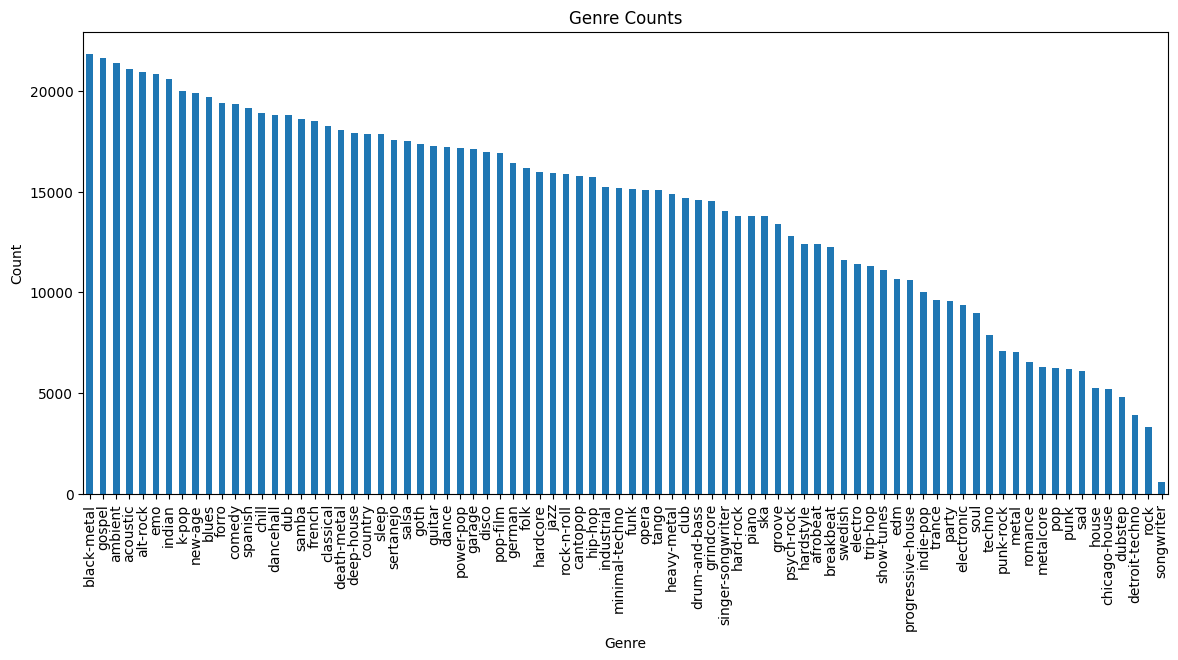

In [37]:
(
    data_original
    .group_by("genre")
    .agg(pl.len().alias("Count"))
    .sort("Count", descending=True)
    .rename({"genre": "Genre"})
).to_pandas().plot.bar(x="Genre", y="Count", figsize=(14, 6), ylabel="Count", legend=None, title="Genre Counts");

Which seems relatively balanced over a largen range of musical styles.

Then, explore correlations in the data by making a pairplot and a correlation matrix. The pariplot shows no clear correlations between the data, but from the correlation matrix we can see some correlated features.

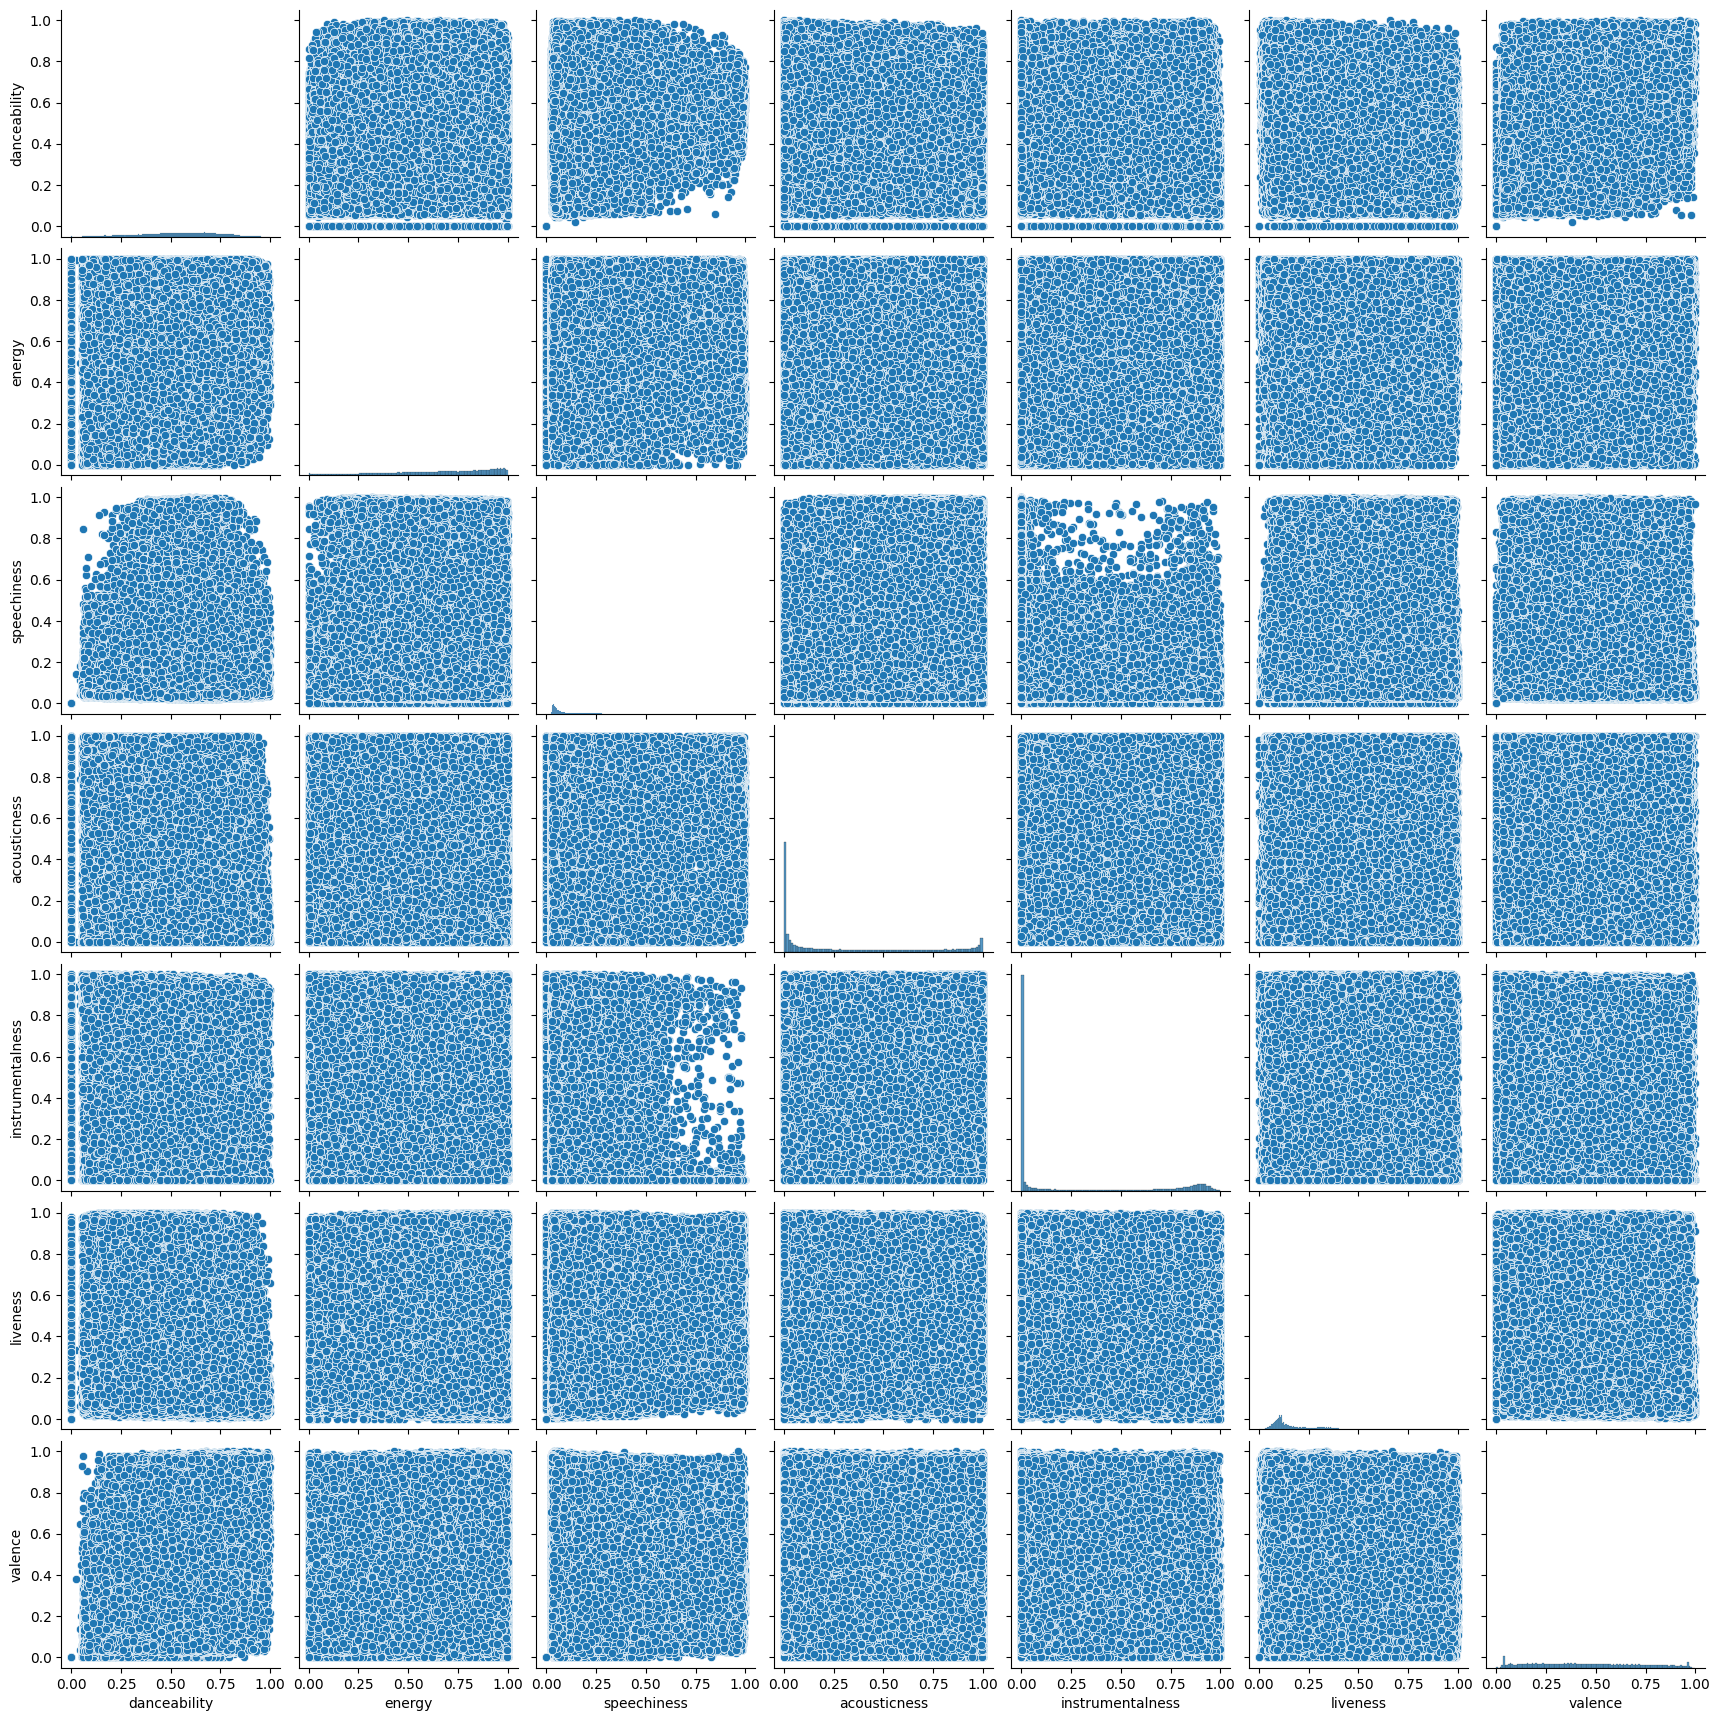

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.pairplot(features.to_pandas())
plt.show()

The pairplot does not give any meaningful insight in what types of correlations we can expect. At least when plotting the data on a 2D projection to the feature axes, we can't see any clustering. 

The only thing that can be glanced from the above plot is
- High speechiness is unlikely to go with middle levels of instrumentalness.
- High speechiness is unlikely to go with low danceability.

The rest of the data seems to be relatively uniformly distributed across the feature space.

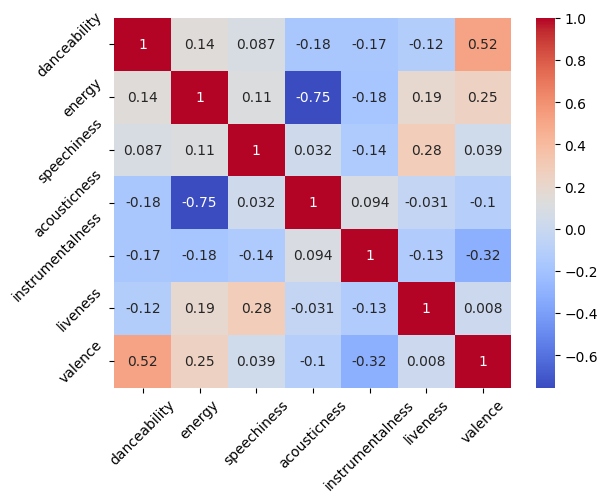

In [38]:
ax = sns.heatmap(
    features.corr(), 
    cmap="coolwarm", 
    annot=True, 
    xticklabels=features.columns, 
    yticklabels=features.columns)
ax.tick_params(labelrotation=45)

Two correlations >0.5 are present between features. 

- (0.52) Valence/Danceability
- (-0.75) Acousticness/Energy

So a lot of high energy songs will likely have a positive sentiment (high valence) and many acoustic songs will likely be low energy.

From this it looks like there is an opportunity for dimensionality reduction. Since no clear grouped datapoints in the form of identifiable clusters were present in the data we can probably get away with taking a lower variance threshold if that means taking fewer components. Later we will be using Gaussian Mixtures to find similarity between groups of points which can be slow on large datasets. Since this is mostly a model that already provides more nuance by yielding probabilities instead of hard class labels, we can do away with some more variance if this means being able to iterate model selection quicker.

## Principal Component Analysis for Dimensionality Reduction

Below we retain a 93.8% variance ratio by keeping only 5 of the PCA components.

In [ ]:
from sklearn.decomposition import PCA
import numpy as np

pca = PCA(random_state=rs).fit(features)
np.cumsum(pca.explained_variance_ratio_)

array([0.39598774, 0.66524087, 0.80423513, 0.89244368, 0.93836124,
       0.97490132, 1.        ])

In [49]:
threshold = 0.938
f"For a variance threshold above {threshold*100:.2f}%, we need to keep {np.searchsorted(np.cumsum(pca.explained_variance_ratio_), threshold) + 1} components"

'For a variance threshold above 93.80%, we need to keep 5 components'

So we can remove two components from the dataset without sacrificing more than ~6% variance.

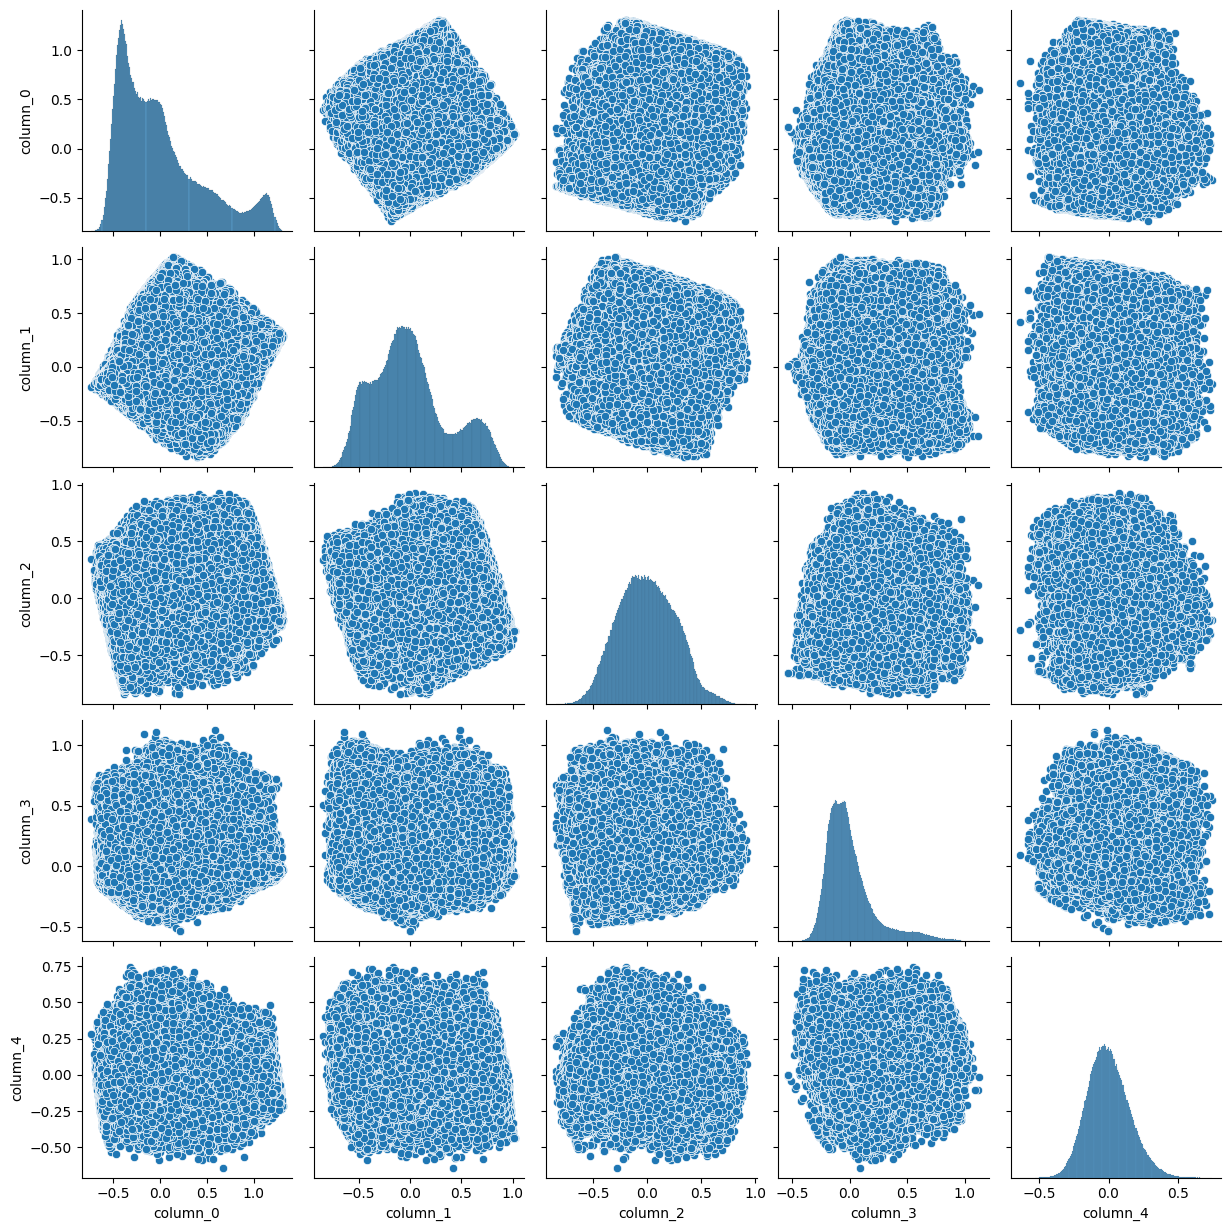

In [50]:
pca = PCA(n_components=5, random_state=rs).fit(features)
features_reduced = pca.transform(features)

sns.pairplot(pl.DataFrame(features_reduced).to_pandas())
plt.show()

From this we can see that there is still no clear clustering visible in this dataset. This is likely due to the fact that different types of music often span large ranges of values for music features and as such will overlap in the feature space. A soft clustering method like GMM might be able to reveal latent groupings (indirectly observable clusters) by allowing probabilistic cluster membership.

## Gaussian Mixtures for more insight

We'll use the previously obtained dimensionality reduced features as input for the Gaussian Mixture model. This clustering method will fit a preselected amount of Gaussians to the data and attempt to assign cluster membership probabilities to each datapoint. Because there is no apparent best choice for the number of components, we'll use model selection for GMM provided by sklearn.

This works by using grid search with a GMM model and providing the following parameters:
- n_components
- covariance_type
- scoring = gmm_bic_score

Where the scoring method is the "Bayesian Information Criterion" (BIC), which is defined as $\text{BIC } = k \ln(n) - 2 \ln(\hat{L})$, where $k$ is the number of parameters in the model, $n$ is the number of data points and $\hat{L}$ is the miximized value of the likelihood function of the model. The goal of this scoring criterion is to avoid overfitting by keeping the number of parameters low. This is similar to using regularization in regression models, but with the number of parameters instead of the size of the parameters.

Before fitting the model though, we need to standardise the dataset to impropve model accuracy. We'll do this by applying `sklearn.preprocessing.StandardScaler`.

In [51]:
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define the bic score as the negative value of the estimator BIC value
gmm_bic_score = lambda estimator, X: -estimator.named_steps['gmm'].bic(estimator.named_steps['scaler'].transform(X))

param_grid = {
    "gmm__n_components": range(4, 10),
    "gmm__covariance_type": ["spherical", "tied", "diag", "full"]
}

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("gmm", GaussianMixture())
    ]
)

gm_gs = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    scoring=gmm_bic_score,
    verbose=2
)
gm_gs.fit(features_reduced)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END gmm__covariance_type=spherical, gmm__n_components=4; total time=   8.1s
[CV] END gmm__covariance_type=spherical, gmm__n_components=4; total time=   4.0s
[CV] END gmm__covariance_type=spherical, gmm__n_components=4; total time=   4.0s
[CV] END gmm__covariance_type=spherical, gmm__n_components=4; total time=   8.8s
[CV] END gmm__covariance_type=spherical, gmm__n_components=4; total time=   4.0s
[CV] END gmm__covariance_type=spherical, gmm__n_components=5; total time=  10.7s
[CV] END gmm__covariance_type=spherical, gmm__n_components=5; total time=  12.7s
[CV] END gmm__covariance_type=spherical, gmm__n_components=5; total time=   5.2s
[CV] END gmm__covariance_type=spherical, gmm__n_components=5; total time=   2.9s
[CV] END gmm__covariance_type=spherical, gmm__n_components=5; total time=   5.3s
[CV] END gmm__covariance_type=spherical, gmm__n_components=6; total time=   4.1s
[CV] END gmm__covariance_type=spherical, gmm__n

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gmm', GaussianMixture())]),
             param_grid={'gmm__covariance_type': ['spherical', 'tied', 'diag',
                                                  'full'],
                         'gmm__n_components': range(4, 10)},
             scoring=<function <lambda> at 0x0000021F262B3A60>, verbose=2)

Using a full variance setting (this correponds to a complete covariance matrix representation), we see that there are 9 components found. Though

We can easily investgate the results by plotting them into a category plot

In [52]:
import pandas as pd

df = pd.DataFrame(gm_gs.cv_results_)[
    ["param_gmm__n_components", "param_gmm__covariance_type", "mean_test_score"]
]
df["mean_test_score"] = -df["mean_test_score"]
df = df.rename(
    columns={
        "param_gmm__n_components": "Number of components",
        "param_gmm__covariance_type": "Type of covariance",
        "mean_test_score": "BIC score",
    }
)
df.sort_values(by="BIC score").head()

Number of components Type of covariance     BIC score
23                     9               full  1.790077e+06
22                     8               full  1.836130e+06
21                     7               full  1.875021e+06
20                     6               full  1.943828e+06
19                     5               full  2.006601e+06

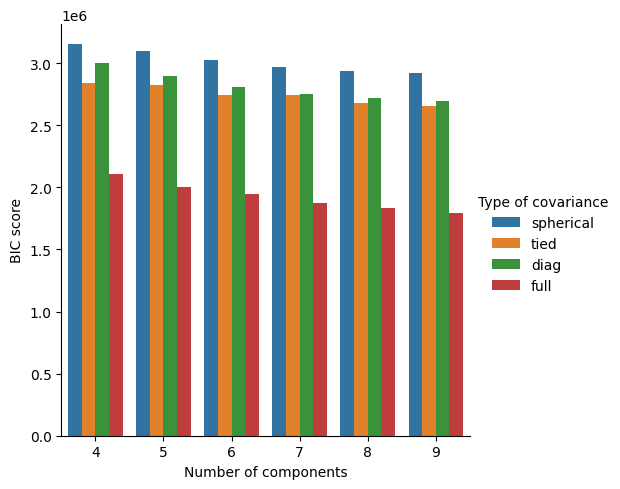

In [53]:
import seaborn as sns

sns.catplot(
    data=df,
    kind="bar",
    x="Number of components",
    y="BIC score",
    hue="Type of covariance",
)
plt.show()

There is no clear indication how many components would be best, but we can redo the gridsearch at a full covariance matrix representation (as it is clear this method works best overall), but with a greater amount of components. By using the BIC criterion there should be a minimum somewhere as we add more components.

In [54]:
param_grid = {
    "gmm__n_components": range(4, 25)
}

pipe = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("gmm", GaussianMixture(covariance_type="full"))
    ]
)

gm_gs = GridSearchCV(
    pipe, 
    param_grid=param_grid, 
    scoring=gmm_bic_score,
    verbose=2
)
gm_gs.fit(features_reduced)

Fitting 5 folds for each of 21 candidates, totalling 105 fits
[CV] END ................................gmm__n_components=4; total time=  33.3s
[CV] END ................................gmm__n_components=4; total time=  10.1s
[CV] END ................................gmm__n_components=4; total time=  18.9s
[CV] END ................................gmm__n_components=4; total time=  23.0s
[CV] END ................................gmm__n_components=4; total time=   8.9s
[CV] END ................................gmm__n_components=5; total time=  19.6s
[CV] END ................................gmm__n_components=5; total time=  27.1s
[CV] END ................................gmm__n_components=5; total time=  27.6s
[CV] END ................................gmm__n_components=5; total time=  29.1s
[CV] END ................................gmm__n_components=5; total time=  14.2s
[CV] END ................................gmm__n_components=6; total time= 1.3min
[CV] END ................................gmm__n

GridSearchCV(estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('gmm', GaussianMixture())]),
             param_grid={'gmm__n_components': range(4, 25)},
             scoring=<function <lambda> at 0x0000021F262B3A60>, verbose=2)

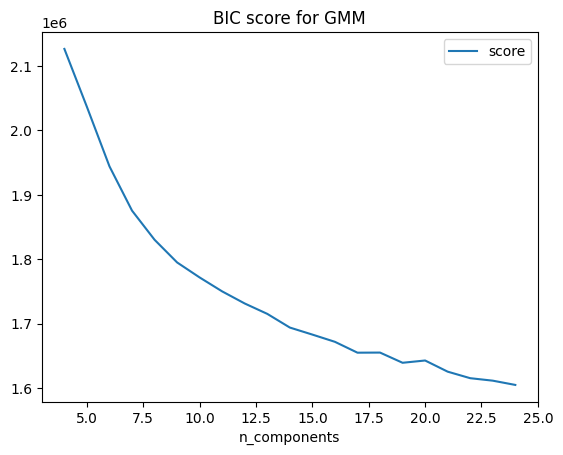

In [58]:
results = pd.DataFrame(gm_gs.cv_results_)[["param_gmm__n_components", "mean_test_score"]]
results = results.rename(columns={"param_gmm__n_components":"n_components", "mean_test_score":"score"})
results["score"] = -results["score"]
results.plot.line("n_components", "score", title="BIC score for GMM");

The absence of a clear BIC minimum shows that there is no inherent clustering in this dataset. With increasing number of components the BIC score *does* decrease, meaning that at least some form of grouping is being captured. From this we can conclude that the musical features as defined by spotify are not good predictors of musical genre as classically defined, which is something we already saw during EDA. However, we can try to see if another set of musical archetypes naturally appears from the analysis.

### GMM model as archetype description

To keep the model interpretable and attempt to keep maximal separation between Gaussian clusters, I have chosen to use 5 Gaussians. The BIC score, while decreasing, never hit a meaningful minimum, so interpretability and insight is more interesting in this case than exact clustering, which is something that this type of dataset does not allow for in any case.

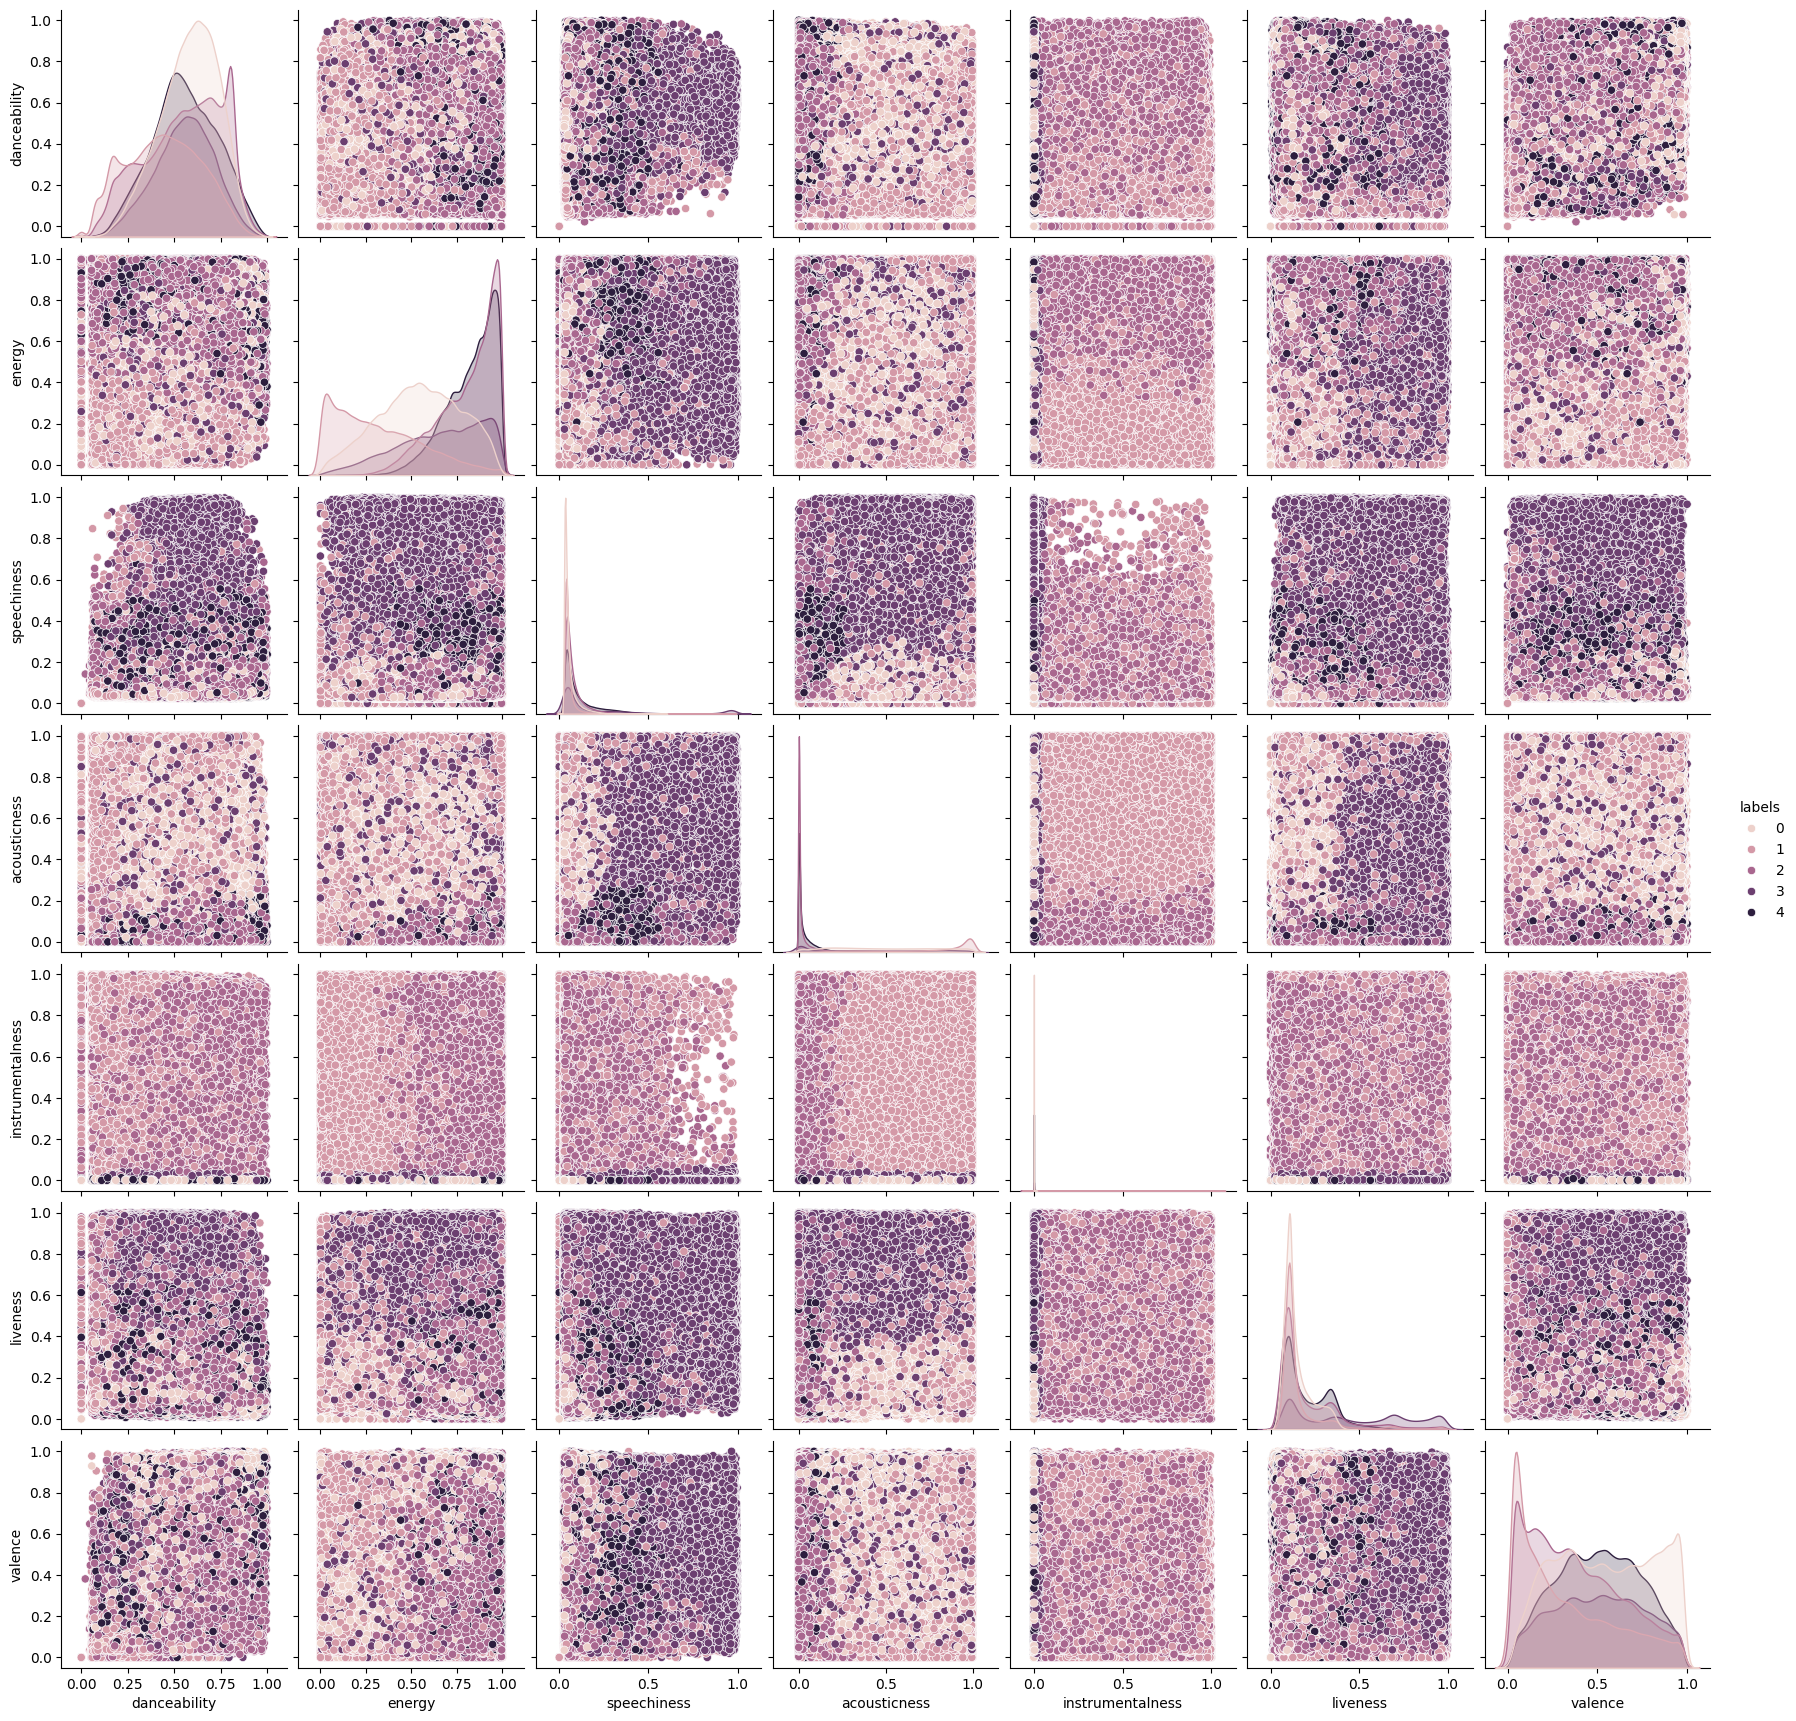

In [56]:
gmm_archetypes = GaussianMixture(n_components=5, covariance_type="full").fit(features_reduced)

labels = gmm_archetypes.predict(features_reduced)

features_gmm_clustered = pl.concat(
    [
        pl.DataFrame(features), 
        pl.DataFrame(labels, schema=["labels"])
    ], 
    how='horizontal')

sns.pairplot(features_gmm_clustered.to_pandas(), hue="labels")
plt.show()

From this we can see that no clear structure emerges from the clustering. Though there are visible groupings and correlations, from this it would be very hard to generalise or form a definitive conclusion.

For more insight we can transform the found means back to original spotify audio feature space using the PCA from before. Then we can interpret each cluster as an archetype of music, instead of specific genres.

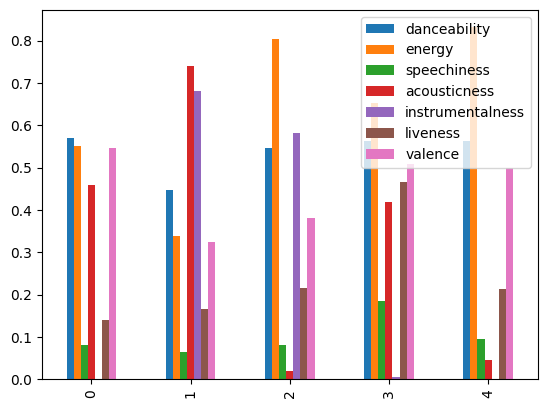

In [144]:
gmm_means = gmm_archetypes.means_
feature_means = pca.inverse_transform(gmm_means)

pd.DataFrame(feature_means, columns=features.columns).plot.bar();

From this we can see that each cluster captures different proportions of each feature. Probably the most pronounced and easily interpretable is cluster 2, with high energy, instrumentalness and danceability and low acousticness and will likely contain lot of electronic dance music. For each cluster the defining features are:

0. Low liveness, instrumentalness and speechiness. Average on all others
1. High acousticness and instrumentalness. Low speechiness.
2. High energy, instrumentalness and danceability. Low speechiness and acousticness.
3. High energy danceability. Low instrumentalness.
4. High energy, danceability. Low speechiness, acousticness, isntrumentalness.

For each of the clusters we can check the most common artist and genre within the cluster.

In [146]:
pl.Config.set_tbl_rows(50)

labels = gmm_archetypes.predict(features_reduced)

grouped_samples = (
    data_original
    .hstack(pl.DataFrame(labels, schema=["label"]))
    .select(["artist_name", "label"])
    .group_by(["label", "artist_name"])
    .agg(pl.len().alias("count"))
    .sort(["label", "count"], descending=[False, True])
    .group_by("label")
    .head(5)
)
grouped_samples

shape: (25, 3)
┌───────┬───────────────────────┬───────┐
│ label ┆ artist_name           ┆ count │
│ ---   ┆ ---                   ┆ ---   │
│ i64   ┆ str                   ┆ u32   │
╞═══════╪═══════════════════════╪═══════╡
│ 0     ┆ Traditional           ┆ 1653  │
│ 0     ┆ Madhu Balakrishnan    ┆ 562   │
│ 0     ┆ Giacomo Meyerbeer     ┆ 516   │
│ 0     ┆ Sonu Nigam            ┆ 467   │
│ 0     ┆ Unnikrishnan          ┆ 406   │
│ 1     ┆ Traditional           ┆ 2025  │
│ 1     ┆ Johann Sebastian Bach ┆ 1741  │
│ 1     ┆ Grateful Dead         ┆ 1206  │
│ 1     ┆ Andrei Krylov         ┆ 826   │
│ 1     ┆ Astor Piazzolla       ┆ 805   │
│ 2     ┆ Armin van Buuren      ┆ 524   │
│ 2     ┆ Orlando Voorn         ┆ 413   │
│ 2     ┆ OnDaMiKe              ┆ 396   │
│ 2     ┆ Huda Hudia            ┆ 387   │
│ 2     ┆ Louie Vega            ┆ 382   │
│ 3     ┆ Grateful Dead         ┆ 734   │
│ 3     ┆ Elvis Presley         ┆ 464   │
│ 3     ┆ Giacomo Meyerbeer     ┆ 413   │
│ 3     ┆ Traditional           ┆ 374   │
│ 3     ┆ Vybz Kartel           ┆ 318   │
│ 4     ┆ Vybz Kartel           ┆ 340   │
│ 4     ┆ Jack Hartmann         ┆ 277   │
│ 4     ┆ Glee Cast             ┆ 242   │
│ 4     ┆ Armin van Buuren      ┆ 238   │
│ 4     ┆ SICK LEGEND           ┆ 220   │
└───────┴───────────────────────┴───────┘

In [154]:
ranked = (
    grouped_samples
    .sort(["label", "count"], descending=[False, True])
    .with_columns(
        pl.int_range(1, pl.len() + 1).over("label").alias("rank")
    )
    .with_columns(
        (pl.col('artist_name') + " (" + pl.col("count").cast(pl.Utf8) + ")")
        .alias("artist_display")
    )
    .select(["rank", "label", "artist_display"])
    .pivot(
        values="artist_display",
        index="rank",
        on="label"    
    )
    .sort("rank")
)
ranked

shape: (5, 6)
┌──────┬──────────────────┬──────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ rank ┆ 0                ┆ 1                ┆ 2               ┆ 3               ┆ 4               │
│ ---  ┆ ---              ┆ ---              ┆ ---             ┆ ---             ┆ ---             │
│ i64  ┆ str              ┆ str              ┆ str             ┆ str             ┆ str             │
╞══════╪══════════════════╪══════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ 1    ┆ Traditional      ┆ Traditional      ┆ Armin van       ┆ Grateful Dead   ┆ Vybz Kartel     │
│      ┆ (1653)           ┆ (2025)           ┆ Buuren (524)    ┆ (734)           ┆ (340)           │
│ 2    ┆ Madhu            ┆ Johann Sebastian ┆ Orlando Voorn   ┆ Elvis Presley   ┆ Jack Hartmann   │
│      ┆ Balakrishnan     ┆ Bach (1741)      ┆ (413)           ┆ (464)           ┆ (277)           │
│      ┆ (562)            ┆                  ┆                 ┆                 ┆                 │
│ 3    ┆ Giacomo          ┆ Grateful Dead    ┆ OnDaMiKe (396)  ┆ Giacomo         ┆ Glee Cast (242) │
│      ┆ Meyerbeer (516)  ┆ (1206)           ┆                 ┆ Meyerbeer (413) ┆                 │
│ 4    ┆ Sonu Nigam (467) ┆ Andrei Krylov    ┆ Huda Hudia      ┆ Traditional     ┆ Armin van       │
│      ┆                  ┆ (826)            ┆ (387)           ┆ (374)           ┆ Buuren (238)    │
│ 5    ┆ Unnikrishnan     ┆ Astor Piazzolla  ┆ Louie Vega      ┆ Vybz Kartel     ┆ SICK LEGEND     │
│      ┆ (406)            ┆ (805)            ┆ (382)           ┆ (318)           ┆ (220)           │
└──────┴──────────────────┴──────────────────┴─────────────────┴─────────────────┴─────────────────┘

In [155]:
grouped_samples = (
    data_original
    .hstack(pl.DataFrame(labels, schema=["label"]))
    .select(["genre", "label"])
    .group_by(["label", "genre"])
    .agg(pl.len().alias("count"))
    .sort(["label", "count"], descending=[False, True])
    .group_by("label")
    .head(5)
)
grouped_samples

shape: (25, 3)
┌───────┬────────────────┬───────┐
│ label ┆ genre          ┆ count │
│ ---   ┆ ---            ┆ ---   │
│ i64   ┆ str            ┆ u32   │
╞═══════╪════════════════╪═══════╡
│ 0     ┆ salsa          ┆ 13035 │
│ 0     ┆ gospel         ┆ 12512 │
│ 0     ┆ forro          ┆ 11965 │
│ 0     ┆ acoustic       ┆ 11072 │
│ 0     ┆ cantopop       ┆ 10935 │
│ 1     ┆ ambient        ┆ 17749 │
│ 1     ┆ new-age        ┆ 17478 │
│ 1     ┆ sleep          ┆ 14004 │
│ 1     ┆ guitar         ┆ 13977 │
│ 1     ┆ classical      ┆ 13811 │
│ 2     ┆ black-metal    ┆ 15752 │
│ 2     ┆ minimal-techno ┆ 13634 │
│ 2     ┆ deep-house     ┆ 12812 │
│ 2     ┆ death-metal    ┆ 11917 │
│ 2     ┆ drum-and-bass  ┆ 11849 │
│ 3     ┆ comedy         ┆ 16477 │
│ 3     ┆ sertanejo      ┆ 6625  │
│ 3     ┆ samba          ┆ 5436  │
│ 3     ┆ forro          ┆ 5141  │
│ 3     ┆ gospel         ┆ 4771  │
│ 4     ┆ emo            ┆ 11072 │
│ 4     ┆ hardcore       ┆ 9550  │
│ 4     ┆ alt-rock       ┆ 9450  │
│ 4     ┆ hip-hop        ┆ 8633  │
│ 4     ┆ dancehall      ┆ 8577  │
└───────┴────────────────┴───────┘

In [156]:
ranked = (
    grouped_samples
    .sort(["label", "count"], descending=[False, True])
    .with_columns(
        pl.int_range(1, pl.len() + 1).over("label").alias("rank")
    )
    .with_columns(
        (pl.col('genre') + " (" + pl.col("count").cast(pl.Utf8) + ")")
        .alias("genre_display")
    )
    .select(["rank", "label", "genre_display"])
    .pivot(
        values="genre_display",
        index="rank",
        on="label"    
    )
    .sort("rank")
)
ranked

shape: (5, 6)
┌──────┬──────────────────┬──────────────────┬─────────────────┬─────────────────┬─────────────────┐
│ rank ┆ 0                ┆ 1                ┆ 2               ┆ 3               ┆ 4               │
│ ---  ┆ ---              ┆ ---              ┆ ---             ┆ ---             ┆ ---             │
│ i64  ┆ str              ┆ str              ┆ str             ┆ str             ┆ str             │
╞══════╪══════════════════╪══════════════════╪═════════════════╪═════════════════╪═════════════════╡
│ 1    ┆ salsa (13035)    ┆ ambient (17749)  ┆ black-metal     ┆ comedy (16477)  ┆ emo (11072)     │
│      ┆                  ┆                  ┆ (15752)         ┆                 ┆                 │
│ 2    ┆ gospel (12512)   ┆ new-age (17478)  ┆ minimal-techno  ┆ sertanejo       ┆ hardcore (9550) │
│      ┆                  ┆                  ┆ (13634)         ┆ (6625)          ┆                 │
│ 3    ┆ forro (11965)    ┆ sleep (14004)    ┆ deep-house      ┆ samba (5436)    ┆ alt-rock (9450) │
│      ┆                  ┆                  ┆ (12812)         ┆                 ┆                 │
│ 4    ┆ acoustic (11072) ┆ guitar (13977)   ┆ death-metal     ┆ forro (5141)    ┆ hip-hop (8633)  │
│      ┆                  ┆                  ┆ (11917)         ┆                 ┆                 │
│ 5    ┆ cantopop (10935) ┆ classical        ┆ drum-and-bass   ┆ gospel (4771)   ┆ dancehall       │
│      ┆                  ┆ (13811)          ┆ (11849)         ┆                 ┆ (8577)          │
└──────┴──────────────────┴──────────────────┴─────────────────┴─────────────────┴─────────────────┘

With this we can interpret the clusters more informatively as:

- **Cluster 0**: Rhythmic & Upbeat Popular. Includes salsa, gospel, brazilian and other popular world music genres.
- **Cluster 1**: Acoustic and Ambient Instrumental. Classical music, instrumental guitar and new-age.
- **Cluster 2**: High-Energy Electronic and Metal. EDM, death-metal and other high energy tracks with few vocals.
- **Cluster 3**: Expressive Vocal & Performance. Comedy, Samba, 
- **Cluster 4**: High-Energy Alternative & Hip-Hop. Alternative rock type music and hip-hop with high energy.

Interestingly, cluster 0 and 3 seem to capture much of the same genres. The main distinction here seems to lie in speechiness and liveness. This is probably because much of this music is meant to be enjoyed live and likely distributed as live albums. This also makes it more likely to contain spoken sections since the artist may be adressing the crowd.

## DBSCAN for cluster validation

An exploratory HDBSCAN clustering was perfomed with min_cluster_size=5000 and min_samples=20. This resulted in only 3 clusters being found with the following distribution:
- "-1": 577914
- "0": 50492
- "1": 481789
- "2": 49569

The AMI score was calculated to find the overlap between the HDBSCAN and GMM results, which came out to 0.535. This shows good agreement in how the distribution of these clusters is between methods. A second HDBSCAN fit was performed with smaller cluster sizes to probe a slightly finer structure and try to recover the 5 clusters from the original data. This was moslty done because approximately half the dataset was dropped as noise.

Because this seemed to miss some of the subtleties from the dataset, another attempt was done by tweaking the minimum cluster size to 2000. By doing this we were able to recover 4 clusters with good correspondence to the results from the Gaussian Model.

In [129]:
from sklearn.cluster import HDBSCAN

ss = StandardScaler()

features_reduced_scaled = ss.fit_transform(features_reduced)

min_cluster_size = 2000
min_samples = 10

hdbs = HDBSCAN(
    min_cluster_size=min_cluster_size, 
    min_samples=min_samples, 
    copy=True, 
    metric="euclidean", 
    cluster_selection_method="eom")
labels = hdbs.fit_predict(features_reduced_scaled)

In [130]:
np.unique(labels), np.unique_counts(labels)

(array([-1,  0,  1,  2,  3]),
 UniqueCountsResult(values=array([-1,  0,  1,  2,  3]), counts=array([599173,   3335,  53556, 457858,  45842])))

In [131]:
from sklearn.metrics import adjusted_mutual_info_score

gmm_labels = gmm_archetypes.predict(features_reduced)
hdbs_labels = labels

mask = labels != -1
ami = adjusted_mutual_info_score(
    gmm_labels[mask],
    hdbs_labels[mask]
)

ami

0.5643351006644073

In [132]:
#np.save("./data/gmm_labels", gmm_labels)
np.save(f"./data/hdbs_labels_{min_cluster_size}_{min_samples}", hdbs_labels)

In [126]:
np.all(np.load("./data/gmm_labels.npy") == gmm_labels), np.all(np.load("./data/hdbs_labels.npy") == hdbs_labels)

(np.True_, np.True_)

With these results we can now create an enhanced dataset with the HDBS clusters as labels and plot the mean values for the audio features for each cluster.

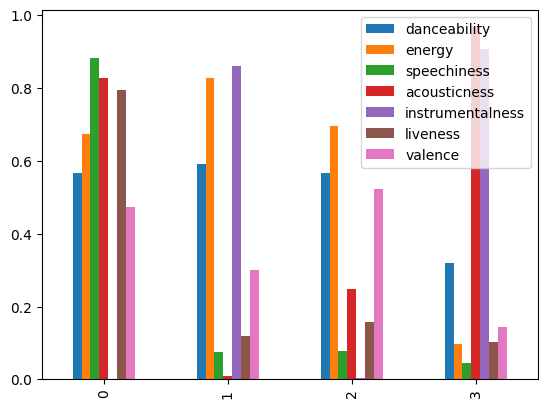

In [140]:
hdbs_cluster_means = (
    data_original
    .select(ps.numeric())
    .select(["danceability", "energy", "speechiness", "acousticness", "instrumentalness", "liveness", "valence"])
    .hstack(pl.DataFrame(hdbs_labels, schema=["hdbs_labels"]))
    .select(pl.all().filter(pl.col("hdbs_labels") != -1))
    .group_by(["hdbs_labels"])
    .mean()
    .sort("hdbs_labels")
)

hdbs_cluster_means.drop("hdbs_labels").to_pandas().plot.bar();

And again we can attempt to interpret the clusters by inspecting which artists are most represented:

In [158]:
grouped_samples = (
    data_original
    .hstack(pl.DataFrame(hdbs_labels, schema=["hdbs_labels"]))
    .select(["artist_name", "hdbs_labels"])
    .select(pl.all().filter(pl.col("hdbs_labels") != -1))
    .group_by(["hdbs_labels", "artist_name"])
    .agg(pl.len().alias("count"))
    .sort(["hdbs_labels", "count"], descending=[False, True])
    .group_by("hdbs_labels")
    .head(5)
)
grouped_samples

shape: (20, 3)
┌─────────────┬───────────────────────┬───────┐
│ hdbs_labels ┆ artist_name           ┆ count │
│ ---         ┆ ---                   ┆ ---   │
│ i64         ┆ str                   ┆ u32   │
╞═════════════╪═══════════════════════╪═══════╡
│ 0           ┆ Jim Norton            ┆ 65    │
│ 0           ┆ Jim Gaffigan          ┆ 52    │
│ 0           ┆ Alonzo Bodden         ┆ 42    │
│ 0           ┆ Kathleen Madigan      ┆ 36    │
│ 0           ┆ Glenn Wool            ┆ 32    │
│ 1           ┆ Boris Brejcha         ┆ 243   │
│ 1           ┆ Orlando Voorn         ┆ 190   │
│ 1           ┆ Frankyeffe            ┆ 172   │
│ 1           ┆ DJ 3000               ┆ 145   │
│ 1           ┆ Niereich              ┆ 135   │
│ 2           ┆ Traditional           ┆ 1273  │
│ 2           ┆ Glee Cast             ┆ 526   │
│ 2           ┆ Vybz Kartel           ┆ 475   │
│ 2           ┆ Giacomo Meyerbeer     ┆ 448   │
│ 2           ┆ Sonu Nigam            ┆ 435   │
│ 3           ┆ Steven Halpern        ┆ 582   │
│ 3           ┆ Traditional           ┆ 523   │
│ 3           ┆ Johann Sebastian Bach ┆ 501   │
│ 3           ┆ Frédéric Chopin       ┆ 452   │
│ 3           ┆ Ludwig van Beethoven  ┆ 418   │
└─────────────┴───────────────────────┴───────┘

In [160]:
ranked = (
    grouped_samples
    .sort(["hdbs_labels", "count"], descending=[False, True])
    .with_columns(
        pl.int_range(1, pl.len() + 1).over("hdbs_labels").alias("rank")
    )
    .with_columns(
        (pl.col('artist_name') + " (" + pl.col("count").cast(pl.Utf8) + ")")
        .alias("artist_display")
    )
    .select(["rank", "hdbs_labels", "artist_display"])
    .pivot(
        values="artist_display",
        index="rank",
        on="hdbs_labels"    
    )
    .sort("rank")
)
ranked

shape: (5, 5)
┌──────┬───────────────────────┬─────────────────────┬──────────────────────┬──────────────────────┐
│ rank ┆ 0                     ┆ 1                   ┆ 2                    ┆ 3                    │
│ ---  ┆ ---                   ┆ ---                 ┆ ---                  ┆ ---                  │
│ i64  ┆ str                   ┆ str                 ┆ str                  ┆ str                  │
╞══════╪═══════════════════════╪═════════════════════╪══════════════════════╪══════════════════════╡
│ 1    ┆ Jim Norton (65)       ┆ Boris Brejcha (243) ┆ Traditional (1273)   ┆ Steven Halpern (582) │
│ 2    ┆ Jim Gaffigan (52)     ┆ Orlando Voorn (190) ┆ Glee Cast (526)      ┆ Traditional (523)    │
│ 3    ┆ Alonzo Bodden (42)    ┆ Frankyeffe (172)    ┆ Vybz Kartel (475)    ┆ Johann Sebastian     │
│      ┆                       ┆                     ┆                      ┆ Bach (501)           │
│ 4    ┆ Kathleen Madigan (36) ┆ DJ 3000 (145)       ┆ Giacomo Meyerbeer    ┆ Frédéric Chopin      │
│      ┆                       ┆                     ┆ (448)                ┆ (452)                │
│ 5    ┆ Glenn Wool (32)       ┆ Niereich (135)      ┆ Sonu Nigam (435)     ┆ Ludwig van Beethoven │
│      ┆                       ┆                     ┆                      ┆ (418)                │
└──────┴───────────────────────┴─────────────────────┴──────────────────────┴──────────────────────┘

And the same for genres:

In [161]:
grouped_samples = (
    data_original
    .hstack(pl.DataFrame(hdbs_labels, schema=["hdbs_labels"]))
    .select(["genre", "hdbs_labels"])
    .select(pl.all().filter(pl.col("hdbs_labels") != -1))
    .group_by(["hdbs_labels", "genre"])
    .agg(pl.len().alias("count"))
    .sort(["hdbs_labels", "count"], descending=[False, True])
    .group_by("hdbs_labels")
    .head(5)
)
grouped_samples

shape: (20, 3)
┌─────────────┬───────────────────┬───────┐
│ hdbs_labels ┆ genre             ┆ count │
│ ---         ┆ ---               ┆ ---   │
│ i64         ┆ str               ┆ u32   │
╞═════════════╪═══════════════════╪═══════╡
│ 0           ┆ comedy            ┆ 3126  │
│ 0           ┆ show-tunes        ┆ 23    │
│ 0           ┆ sertanejo         ┆ 23    │
│ 0           ┆ samba             ┆ 23    │
│ 0           ┆ singer-songwriter ┆ 12    │
│ 1           ┆ minimal-techno    ┆ 7054  │
│ 1           ┆ black-metal       ┆ 4021  │
│ 1           ┆ deep-house        ┆ 3847  │
│ 1           ┆ drum-and-bass     ┆ 2997  │
│ 1           ┆ grindcore         ┆ 2830  │
│ 2           ┆ k-pop             ┆ 14144 │
│ 2           ┆ alt-rock          ┆ 13676 │
│ 2           ┆ country           ┆ 13212 │
│ 2           ┆ emo               ┆ 13059 │
│ 2           ┆ spanish           ┆ 12035 │
│ 3           ┆ new-age           ┆ 9152  │
│ 3           ┆ ambient           ┆ 7368  │
│ 3           ┆ classical         ┆ 6728  │
│ 3           ┆ sleep             ┆ 5582  │
│ 3           ┆ piano             ┆ 5354  │
└─────────────┴───────────────────┴───────┘

In [162]:
ranked = (
    grouped_samples
    .sort(["hdbs_labels", "count"], descending=[False, True])
    .with_columns(
        pl.int_range(1, pl.len() + 1).over("hdbs_labels").alias("rank")
    )
    .with_columns(
        (pl.col('genre') + " (" + pl.col("count").cast(pl.Utf8) + ")")
        .alias("genre_display")
    )
    .select(["rank", "hdbs_labels", "genre_display"])
    .pivot(
        values="genre_display",
        index="rank",
        on="hdbs_labels"    
    )
    .sort("rank")
)
ranked

shape: (5, 5)
┌──────┬────────────────────────┬───────────────────────┬──────────────────┬──────────────────┐
│ rank ┆ 0                      ┆ 1                     ┆ 2                ┆ 3                │
│ ---  ┆ ---                    ┆ ---                   ┆ ---              ┆ ---              │
│ i64  ┆ str                    ┆ str                   ┆ str              ┆ str              │
╞══════╪════════════════════════╪═══════════════════════╪══════════════════╪══════════════════╡
│ 1    ┆ comedy (3126)          ┆ minimal-techno (7054) ┆ k-pop (14144)    ┆ new-age (9152)   │
│ 2    ┆ show-tunes (23)        ┆ black-metal (4021)    ┆ alt-rock (13676) ┆ ambient (7368)   │
│ 3    ┆ sertanejo (23)         ┆ deep-house (3847)     ┆ country (13212)  ┆ classical (6728) │
│ 4    ┆ samba (23)             ┆ drum-and-bass (2997)  ┆ emo (13059)      ┆ sleep (5582)     │
│ 5    ┆ singer-songwriter (12) ┆ grindcore (2830)      ┆ spanish (12035)  ┆ piano (5354)     │
└──────┴────────────────────────┴───────────────────────┴──────────────────┴──────────────────┘

From this we can see that the combination of features largely correlates with the clusters found earlier with GMM. The following clusters can be identified:

- **0** - Expressive Vocal & Performance. Comedy, Samba. (Corresponding to cluster 3 from the GMM model).
- **1** - High-Energy Electronic and Metal. EDM, death-metal and other high energy tracks with few vocals. (Corresponding to Cluster 2 from the GMM model)
- **2** - Popular music, easy to listen to. (Has fewer direct correspondence with GMM, but contains features from both GMM cluster 0 and cluster 4)
- **3** - Acoustic and Ambient Instrumental. Classical music, instrumental guitar and new-age. (Corresponding to cluster 1 from the GMM model.)

There is good overall agreement with the two methods, as also indicated by the AMI score of 0.56. One thing to note is that HDBS cluster 0 is very small. So the distinction here is not as clear as desired. In the GMM clusters this was also the smallest cluster (byt a much smaller margin) but this might be instructive for further research. It would be interesting to see which tracks were not able to be classified by the HDBS method (approximately half the dataset was not assigned to a cluster) and to see if performance increases with more detailed feature selection or hyperparameter tuning.

## Summary and Reflection

Since this analysis was only applied to a small subset of tracks available on spotify, there are large groups of music types and represenation missing. However, the form of the analysis is still insightful. By using PCA to remove two of the features we can significantly reduce the dimensionality of the audio features space while keeping approximately 93% of the variance. This suggests that there is some redundancy in the way these are defined and that audio features are correlated. This also follows from a correlation matrix which indicates that danceability/valence and acousticness/energy are correlated.

Next we clustered the data using Gaussian Mixtures and found that there is no natural clustering of this dataset. However, using 5 clusters (chosen to keep interpretability as high as possible), we see that the data splits up into meaningfully distinct archetypes which also enlighten why some of the audio features had moderate to high correlation.

Finally a separate analysis was done with HDBSCAN to validate the clusters found with GMM. This analysis largely agreed with the GMM results and showed that a few archetypes clearly emerge. Though much of the data was not able to be classified by the HDBS method and more research would be required to make a definitive comparison.